# Business Understanding

# Data Engineering

## Import Libraries

In [392]:
# import libraries required to load, transform, analyze and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', 
        rc={'figure.facecolor':'white'}, font_scale=1.2)

from collections import Counter
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import en_core_web_sm
from sklearn.utils.class_weight import compute_sample_weight
from spacy.tokenizer import _get_regex_pattern
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from keras.preprocessing import text, sequence
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, LeakyReLU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as k
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

## Dataframe Basics

### Load File

In [3]:
# load primary source file to df, renaming columns, dropping non-ASCII
col_names = ['tweet_text', 'directed_at', 'emotion_label']
tweets = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape', names=col_names, header=0)
tweets.head()


,tweet_text,directed_at,emotion_label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### Data Values

In [4]:
# review data types and null counts
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_text     9092 non-null   object
 1   directed_at    3291 non-null   object
 2   emotion_label  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# drop nan tweets from dataframe
tweets.dropna(subset = ['tweet_text'], inplace=True)
tweets.shape

(9092, 3)

In [6]:
# check value counts by column
print(tweets['directed_at'].value_counts(normalize=True, dropna=False))

NaN                               0.638
iPad                              0.104
Apple                             0.073
iPad or iPhone App                0.052
Google                            0.047
iPhone                            0.033
Other Google product or service   0.032
Android App                       0.009
Android                           0.009
Other Apple product or service    0.004
Name: directed_at, dtype: float64


In [7]:
# create brand feature
tweets['directed_at'].fillna('None', inplace=True)
brand_map = {'iPad': 'Apple', 'Apple': 'Apple', 'iPad or iPhone App': 'Apple', 
             'Google': 'Google', 'iPhone': 'Apple', 
             'Other Google product or service': 'Google',
            'Android App': 'Google', 'Android': 'Google',
             'Other Apple product or service': 'Apple',
             'None': 'None'
            }
tweets['brand'] = tweets.directed_at.map(brand_map, na_action='ignore')

In [8]:
# clean emotion labels
tweets['emotion_label'].replace({'No emotion toward brand or product': 'Neutral',
                                 'Positive emotion': 'Positive', 
                                 'Negative emotion': 'Negative', 
                                 'I can\'t tell': 'Unknown'}, inplace=True)

# check value counts by column
print(tweets['emotion_label'].value_counts(normalize=True, dropna=False))

Neutral    0.593
Positive   0.328
Negative   0.063
Unknown    0.017
Name: emotion_label, dtype: float64


In [9]:
# check value counts by column
tweets.groupby(by=['brand', 'emotion_label'])['tweet_text'].count()

brand   emotion_label
Apple   Negative          388
        Neutral            65
        Positive         1949
        Unknown             7
Google  Negative          131
        Neutral            26
        Positive          723
        Unknown             2
None    Negative           51
        Neutral          5297
        Positive          306
        Unknown           147
Name: tweet_text, dtype: int64

## Tweet Text Clean

In [10]:
def remove_punctuation(x):
    """
    Helper function to remove punctuation from a string x: any string
    """
    punctuation = set(string.punctuation) # punctuation of English language
    punctuation.remove('#') # remove # so hashtags remain in x

    x = re.sub('@[A-Za-z0-9]+', '', x) # remove @mention users
    x = re.sub(r'http\S+', '', x) # remove URL references
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers  
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    return x

In [11]:
# function to clean text
def  clean_text(df, text_field, new_text_field):
    df[new_text_field] = df[text_field].str.lower()
    df[new_text_field] = df[new_text_field].apply(remove_punctuation) 
    return df

In [12]:
tweets_clean = clean_text(tweets, 'tweet_text', 'tweet_text_clean')
tweets_clean.head()

,tweet_text,directed_at,emotion_label,brand,tweet_text_clean
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress


In [13]:
# 
nlp = en_core_web_sm.load()
print(nlp.pipe_names)

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

['tagger', 'parser', 'ner']


In [14]:
# 
stops_sp = nlp.Defaults.stop_words
print(f'spaCy Stopword Count: {len(stops_sp)}')

def clean_token(doc):
    return [token.lemma_ for token in doc if not token.is_stop 
            and not token.is_punct and not token.is_digit 
            and not token.is_space]

tweets['tokens_sp'] = [clean_token(nlp(row)) for row in tweets.tweet_text_clean.apply(str)]

tweets.head()

spaCy Stopword Count: 326


,tweet_text,directed_at,emotion_label,brand,tweet_text_clean,tokens_sp
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,"[g, iphone, hrs, tweet, #riseaustin, dead, need, upgrade, plugin, station, #sxsw]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw,"[know, awesome, ipadiphone, app, will, likely, appreciate, design, give, free, ts, #sxsw]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw,"[wait, #ipad, sale, #sxsw]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw,"[hope, year, festival, not, crashy, year, iphone, app, #sxsw]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,"[great, stuff, fri, #sxsw, marissa, mayer, google, tim, oreilly, tech, booksconference, amp, matt, mullenweg, wordpress]"


In [ ]:
# 
word_dict = {}

# Loop through all the tags
for i, row in tweets['tokens_sp'].iteritems():
    for word in row:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] +=1

word_counts = sorted(word_dict.items(), key=lambda kv: kv[1], reverse=True)
print(f'Total words: {len(word_counts)}')
word_counts[:25]

## Tweet Cloud

In [382]:
# importing and creating a twitter mask 
twitter_mask = np.array(Image.open('images/twitter_mask.png'))

In [406]:
# word tokenize and lowercase all words 
negative_tweets = " ".join(tweet for tweet in tweets[tweets.emotion_label == 'Negative'].tweet_text.astype(str))
positive_tweets = " ".join(tweet for tweet in tweets[tweets.emotion_label == 'Positive'].tweet_text.astype(str))

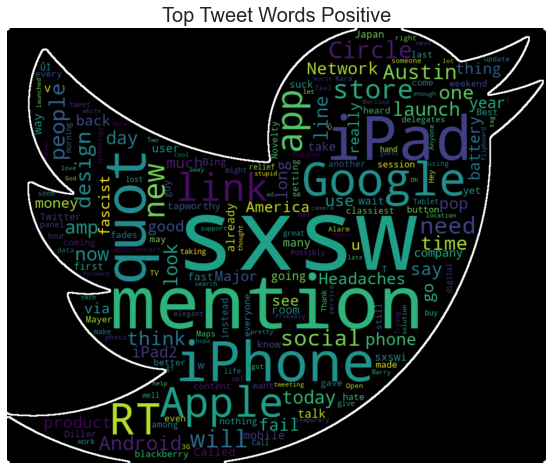

In [427]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud1 = WordCloud(collocations=False, mask=twitter_mask, 
                      background_color='black', width=600,
                      height=485, contour_color='white', contour_width=4)

wordcloud1.generate(positive_tweets)

plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Tweet Words Positive', size=20)
plt.axis('off')
plt.show()

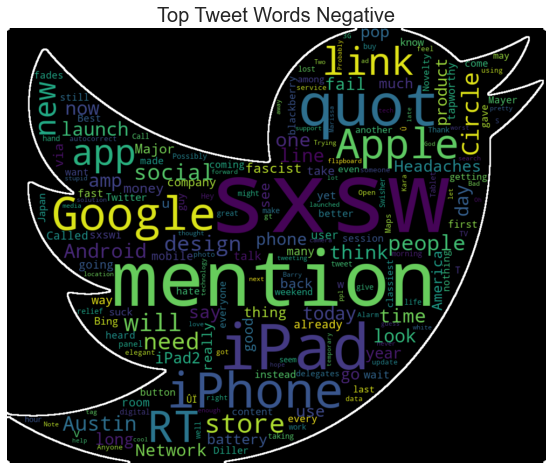

In [428]:
# generating a wordcloud with a twitter mask for negative words only 
wordcloud2 = WordCloud(collocations=False, mask=twitter_mask, 
                      background_color='black', width=600,
                      height=485, contour_color='white', contour_width=4)

wordcloud2.generate(negative_tweets)

plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Top Tweet Words Negative', size=20)
plt.axis('off')
plt.show()

# Data Analysis

# Predictive Models

## Train-Test Split

In [355]:
# filter tweets for identifiable emotions only (drop unknown)
SEED = 19
sentiments = ['Positive', 'Negative', 'Neutral']
tweets_f = tweets[tweets['emotion_label'].isin(sentiments)]

# create X and y (one-hot encoded for 3 classes)
Xt = tweets_f['tokens_sp']
X = tweets_f['tweet_text_clean']
y = pd.get_dummies(tweets_f['emotion_label'])
print(X.iloc[:3], y.iloc[:3])

0           i have a 3g iphone after  hrs tweeting at #riseaustin it was dead  i need to upgrade plugin stations at #sxsw
1     know about   awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw
2                                                        can not wait for #ipad  also they should sale them down at #sxsw
Name: tweet_text_clean, dtype: object    Negative  Neutral  Positive
0         1        0         0
1         0        0         1
2         0        0         1


In [356]:
def TrainTestSplit(X, y):
    # keras tokenize sequences with padding
    t = text.Tokenizer(oov_token=1)
    t.fit_on_texts(X)
    X_seq = t.texts_to_sequences(X)
    X_seq_pad = sequence.pad_sequences(X_seq, padding='post') 
    X_seq_df = pd.DataFrame(data=X_seq_pad, index=X.index.copy())
   
    # Split into training and test sets for cleaned text
    SEED = 19
    X_train, X_test, y_train, y_test = train_test_split(
        X_seq_df, y, test_size=0.20, stratify=y, random_state=SEED)

    print(f'X_train: {X_train.shape} X_test: {X_test.shape} ' 
          f'y_train: {y_train.shape} y_test: {y_test.shape}')

    # set parameters for model input
    doc_cnt = X_train.shape[0]
    vocab_size = len(t.word_index)+1
    input_length = X_train.shape[1]

    print(f'Document count: {doc_cnt} | '
          f'Vocab size: {vocab_size} | '
          f'Input length: {input_length} '
         )
    return t, X_train, X_test, y_train, y_test, doc_cnt, vocab_size, input_length

In [357]:
#
X_tok, X_train, X_test, y_train, y_test, doc_cnt, vocab_size, input_length = TrainTestSplit(X, y)

X_train: (7148, 30) X_test: (1788, 30) y_train: (7148, 3) y_test: (1788, 3)
Document count: 7148 | Vocab size: 10565 | Input length: 30 


In [53]:
#
Xt_tok, Xt_train, Xt_test, yt_train, yt_test, doc_cnt2, vocab_size2, \
    input_length2 = TrainTestSplit(Xt, y)

X_train: (7148, 23) X_test: (1788, 23) y_train: (7148, 3) y_test: (1788, 3)
Document count: 7148 | Vocab size: 9435 | Input length: 23 


In [358]:
# compute sample weights
y_targets = y_train.iloc[:, 0:3]
weights = compute_sample_weight('balanced', y=y_targets)
weights

array([0.33210576, 0.33210576, 7.40171524, ..., 0.33210576, 1.00914498,
       0.33210576])

## Model Functions

In [255]:
def plot_accuracy(history, model_name):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model Accuracy: {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [281]:
def predict(model, X, y_true):
    classes = ['Negative', 'Neutral', 'Positive']
    y_hat = model.predict(X)
    y_hat_cl = pd.DataFrame((y_hat == y_hat.max(axis=1, 
                                                keepdims=True)).astype(int), 
                                                columns=classes,
                                                index=X.index.copy())
    y_hat = pd.DataFrame(y_hat,columns=classes, index=X.index.copy())
    return y_hat, y_hat_cl

In [241]:
def create_pred_class(y):
    y_piv = y.copy()
    y_piv['pred_class'] = y_piv.apply(lambda row: 
                                      pivot_predictions(row.Negative, 
                                                        row.Neutral, 
                                                        row.Positive), 
                                      axis=1)
    return y_piv

In [213]:
def pivot_predictions(neg, neut, pos):
    pred_class = 'Unknown'
    if neg == 1:
        pred_class = 'Negative'
    elif neut == 1:
        pred_class = 'Neutral'
    elif pos == 1:
        pred_class = 'Positive'
    return pred_class

In [248]:
# Plot confusion matrix 
def plot_confusion(y_true, y_hat, model_name):   
    cnf_matrix  = confusion_matrix(y_true, y_hat)
    cmap = plt.get_cmap('Blues')
    cmd = ConfusionMatrixDisplay(cnf_matrix, 
                                 display_labels=['Negative', 'Neutral', 
                                                 'Positive'])
    cmd.plot(cmap=cmap)
    plt.title(f'Confusion Matrix for Model: {model_name}')
    plt.tight_layout()
    plt.show()
    print(classification_report(y_true, y_hat))
    return cnf_matrix

## m0 - SVM

In [ ]:
# instantiate SVC()
svc = SVC(class_weight='balanced')

## m1 - LSTM Embed Tweets Cleaned

In [39]:
# instantiate keras sequential LSTM model layers with embeddings
m1 = Sequential(name="m1_seq_lstm")
m1.add(Embedding(input_dim=vocab_size, 
                    output_dim=128, 
                    input_length=input_length
                    ))
m1.add(LSTM(64, return_sequences=True))
m1.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
m1.add(Dropout(0.15)) # drop out lower or remove (regularization)
m1.add(Dense(32, activation='relu'))
m1.add(Dense(3, activation='softmax'))

In [40]:
# compile model and print summary
m1.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
m1.summary()

Model: "m1_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 128)           1352320   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 1,403,907
Trainable params: 1,403,907
Non-trainable params: 0
_____________________________________________

In [41]:
# Define the callbacks, early stopping and save final model
early_stop_m1 = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m1.h5', monitor='val_loss',
                                  save_best_only=True)]

m1.fit(X_train, y_train, epochs=50, callbacks=early_stop_m1, 
       validation_split=0.15, shuffle=True, batch_size=64)


/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 13s 2ms/step - loss: 0.8644 - accuracy: 0.6028 - val_loss: 0.8073 - val_accuracy: 0.5993
Epoch 2/50
6075/6075 [==============================] - 11s 2ms/step - loss: 0.7143 - accuracy: 0.6935 - val_loss: 0.7444 - val_accuracy: 0.6608
Epoch 3/50
6075/6075 [==============================] - 11s 2ms/step - loss: 0.5566 - accuracy: 0.7822 - val_loss: 0.7546 - val_accuracy: 0.6803
Epoch 4/50
6075/6075 [==============================] - 11s 2ms/step - loss: 0.4379 - accuracy: 0.8333 - val_loss: 0.8360 - val_accuracy: 0.6449
Epoch 5/50
6075/6075 [==============================] - 11s 2ms/step - loss: 0.3209 - accuracy: 0.8765 - val_loss: 0.8593 - val_accuracy: 0.6859


## m2 - LSTM Embed Tweet Tokens

In [42]:
# instantiate keras sequential LSTM model layers with embeddings
model = Sequential(name="m2_seq_lstm")
model.add(Embedding(input_dim=vocab_size2, 
                    output_dim=64, 
                    input_length=input_length2
                    ))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
model.add(Dropout(0.15)) # drop out lower or remove (regularization)
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [43]:
# compile model and print summary
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "m2_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 23, 64)            603840    
_________________________________________________________________
lstm_5 (LSTM)                (None, 23, 64)            33024     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 99        
Total params: 639,043
Trainable params: 639,043
Non-trainable params: 0
_________________________________________________

In [44]:
# Define the callbacks, early stopping and save final model
early_stop = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m2.h5', monitor='val_loss',
                                  save_best_only=True)]

model.fit(Xt_train, yt_train, epochs=50, callbacks=early_stop,
          validation_split=0.15, shuffle=True, batch_size=64) 

/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 9s 2ms/step - loss: 0.8824 - accuracy: 0.6035 - val_loss: 0.8297 - val_accuracy: 0.5983
Epoch 2/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.7407 - accuracy: 0.6754 - val_loss: 0.7377 - val_accuracy: 0.6533
Epoch 3/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.5305 - accuracy: 0.7834 - val_loss: 0.7393 - val_accuracy: 0.6813
Epoch 4/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.3870 - accuracy: 0.8540 - val_loss: 0.8238 - val_accuracy: 0.6580
Epoch 5/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.3059 - accuracy: 0.8830 - val_loss: 0.9182 - val_accuracy: 0.6785


Notes 
- Visualize n-grams or word clouts or frequency association
- Word embeddings - Glove vectors
- Encode with Bag of Words/TGIDF with RF (helps with interpretability) - helps link complexity; still could use NN (basic dense)

## m3 - LSTM Embed Glove

In [359]:
# establish total vocabulary prior to fetching Glove vectors
t0 = text.Tokenizer(oov_token=1)
t0.fit_on_texts(X)
vocab = list(t0.word_counts.keys())
print(f'Total tweet vocabulary is: {len(vocab)}')

Total tweet vocabulary is: 10563


In [360]:
# create glove dictionary of embedding vectors for vocab list
glove_file = 'data/glove.twitter.27B.200d.txt'
glove = {}
with open(glove_file, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [361]:
# Number of dimensions of the GloVe word embeddings
glove_dim = len(next(iter(glove.values())))  

emb_matrix = np.zeros((vocab_size, glove_dim))
for w, i in X_tok.word_index.items():
    vect = glove.get(w)
    if vect is not None:
        emb_matrix[i] = vect

In [362]:
# instantiate keras sequential LSTM model layers with embeddings
m3 = Sequential(name="m3_seq_lstm_glove")
m3.add(Embedding(input_dim=vocab_size, 
                 output_dim=glove_dim, 
                 input_length=input_length,
                 weights=[emb_matrix], 
                 trainable=False
                    ))
m3.add(SpatialDropout1D(0.2))
m3.add(LSTM(128, return_sequences=True))
m3.add(Bidirectional(LSTM(128, dropout=0.15, recurrent_dropout=0.15, return_sequences=True)))
m3.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
m3.add(Dense(64, activation="relu")) 
m3.add(Dense(32, activation="relu"))
m3.add(Dense(3, activation='softmax'))

In [363]:
# compile model and print summary
opt = optimizers.SGD(lr=0.1, momentum=0.90) 
m3.compile(loss='categorical_crossentropy', optimizer=opt, # 'binary_crossentropy'
              metrics=['accuracy'])
m3.summary()
# RMSprop(learning_rate=0.001, rho=0.9)

Model: "m3_seq_lstm_glove"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 200)           2113000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 200)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 128)           168448    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 256)           263168    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 32)          

In [364]:
# Define the callbacks, early stopping and save final model
early_stop_m3 = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m3.h5', monitor='val_loss',
                                  save_best_only=True)]

# optimizer=RMSprop(lr=learning_rate)
m3_fit = m3.fit(X_train, y_train, epochs=50, sample_weight=weights, 
                callbacks=early_stop_m3, validation_split=0.15, shuffle=True,
                batch_size=32)

Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 51s 8ms/step - loss: 1.0715 - accuracy: 0.1075 - val_loss: 1.0609 - val_accuracy: 0.0643
Epoch 2/50
6075/6075 [==============================] - 48s 8ms/step - loss: 1.0620 - accuracy: 0.0925 - val_loss: 1.0595 - val_accuracy: 0.0643
Epoch 3/50
6075/6075 [==============================] - 49s 8ms/step - loss: 1.0631 - accuracy: 0.1073 - val_loss: 1.0652 - val_accuracy: 0.2488
Epoch 4/50
6075/6075 [==============================] - 49s 8ms/step - loss: 1.0619 - accuracy: 0.1016 - val_loss: 1.0811 - val_accuracy: 0.0643
Epoch 5/50
6075/6075 [==============================] - 48s 8ms/step - loss: 1.0627 - accuracy: 0.0907 - val_loss: 1.0626 - val_accuracy: 0.0643


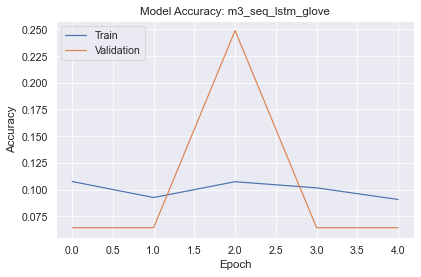

In [365]:
# extract history from model and plot epoch accuracy trend
m3_hist = m3_fit.history
plot_accuracy(m3_hist, m3.name)

In [366]:
# create predictions for model
y_hat_m3, y_hat_cl_m3 = predict(m3, X_train, y_train)

In [367]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_train_piv = create_pred_class(y_train)
y_hat_cl_m3_piv = create_pred_class(y_hat_cl_m3_piv)

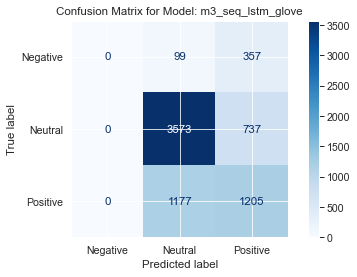

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       456
     Neutral       0.74      0.83      0.78      4310
    Positive       0.52      0.51      0.51      2382

    accuracy                           0.67      7148
   macro avg       0.42      0.44      0.43      7148
weighted avg       0.62      0.67      0.64      7148



/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [368]:
# plot confusion matrix and classification report
cnf_matrix_m3 = plot_confusion(y_train_piv.pred_class, 
                               y_hat_cl_m3_piv.pred_class,
                               m3.name)

In [375]:

Xy_train_m3 = pd.concat([X, y_train_piv.iloc[:, 3], y_hat_cl_m3_piv.iloc[:, 3], y_hat_m3], axis=1, join='inner')
Xy_train_m3.columns.values[1] = 'act_class'
Xy_train_m3.columns.values[3] = 'p_negative'
Xy_train_m3.columns.values[4] = 'p_neutral'
Xy_train_m3.columns.values[5] = 'p_positive'
Xy_train_m3

,tweet_text_clean,act_class,pred_class,p_negative,p_neutral,p_positive
1,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw,Positive,Positive,0.433,0.200,0.368
2,can not wait for #ipad also they should sale them down at #sxsw,Positive,Positive,0.432,0.200,0.368
3,i hope this years festival isnt as crashy as this years iphone app #sxsw,Negative,Positive,0.433,0.200,0.368
4,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,Positive,Neutral,0.433,0.200,0.367
5,new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference #iear #edchat #asd,Neutral,Neutral,0.432,0.200,0.368
...,...,...,...,...,...,...
9087,yup but i dont have a third app yet im on android any suggestions #sxsw cc,Neutral,Positive,0.432,0.200,0.368
9088,ipad everywhere #sxsw link,Positive,Positive,0.433,0.200,0.368
9089,wave buzz rt we interrupt your regularly scheduled #sxsw geek programming with big news link #google #circles,Neutral,Neutral,0.433,0.200,0.367
9090,googles zeiger a physician never reported potential ae yet fda relies on physicians quotwere operating wout dataquot #sxsw #health2dev,Neutral,Neutral,0.433,0.200,0.368
